In [1]:
import random
import pylab as plt
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import os
import copy
import json

import warnings

from tqdm.auto import tqdm
from sklearn import datasets

import ray
from ray import tune
from ray.tune import Trainable
from ray import air
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

In [2]:
def build_dataset(n_samples, val_set_size, test_set_size=100, ds_noise=0.05, seed=42):
    assert n_samples > test_set_size+val_set_size, "Test and Val Set should be smaller than n_samples"

    X, y = datasets.make_moons(n_samples, noise=ds_noise, random_state=seed)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()

    random.seed(seed)
    test_indices = random.sample(range(X.shape[0]), k=test_set_size)
    free_indices = [i for i in range(X.shape[0]) if i not in test_indices]
    val_indices = random.sample(free_indices, k=val_set_size)
    train_indices = [i for i in range(X.shape[0]) if i not in test_indices and i not in val_indices]

    train_ds = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    val_ds = torch.utils.data.TensorDataset(X[val_indices], y[val_indices])
    test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_ds, val_ds, test_ds

In [3]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU(), nn.Linear(feature_dim, feature_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        x = self.base_encoder(x)
        x = self.fc(x)
        return x

In [4]:
class TrainableNN(Trainable):
    def setup(self, config, args):
        self.timestep = 0
        self.config = config
        self.args = args
        
        torch.manual_seed(args['random_seed'])
        self.model = Net(args['n_classes'], config['feature_dim'])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config['learning_rate'], momentum=0.9, weight_decay=config['weight_decay'], nesterov=True)
        self.criterion = nn.CrossEntropyLoss()
        self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=args['n_epochs']-args['n_epochs_warmup'])
        self.device = args['device']

        self.train_ds, self.val_ds, _ = build_dataset(n_samples=args['n_samples'], test_set_size=args['test_set_size'], val_set_size=args['val_set_size'], ds_noise=args['ds_noise'], seed=args['random_seed'])
        self.train_loader = torch.utils.data.DataLoader(self.train_ds, batch_size=args['batch_size'], shuffle=True, drop_last=True)
        self.val_loader = torch.utils.data.DataLoader(self.val_ds, batch_size=64, shuffle=False, drop_last=False)


    def step(self):
        for i in range(self.args['step_size']):
            _ = self.train_one_epoch(self.train_loader)
            if self.timestep * self.args['step_size'] + i > self.args['n_epochs_warmup']:
                self.lr_scheduler.step()
        self.timestep += 1
        val_stats = self.evaluate(self.val_loader)
        return {'val_acc': val_stats['acc']}
    

    def train_one_epoch(self, dataloader):
        self.model.train()
        self.model.to(self.device)
        self.criterion.to(self.device)

        total_loss, n_samples, n_correct = 0, 0, 0 

        # Train the epoch
        for (x, y) in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            batch_size = x.shape[0]

            out = self.model(x)
            loss = self.criterion(out, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch_size
            n_samples += batch_size
            n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

        return {
            'loss':total_loss/n_samples, 
            'acc':n_correct/n_samples*100
            }
    

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        self.model.to(self.device)
        self.criterion.to(self.device)

        total_loss, n_samples, n_correct = 0, 0, 0 

        # Train the epoch
        for (x, y) in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            batch_size = x.shape[0]

            out = self.model(x)
            loss = self.criterion(out, y)

            total_loss += loss.item() * batch_size
            n_samples += batch_size
            n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

        return {
            'loss':total_loss/n_samples, 
            'acc':n_correct/n_samples*100
            }


    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))

In [5]:
args = {
    "random_seed":42,
    "device":'cuda',

    "n_samples":450,
    "test_set_size":150,
    "val_set_size":50,
    "ds_noise":0.1,
    
    "n_epochs_warmup":10,
    "n_epochs":100,
    "learning_rate": tune.uniform(1e-4, .1),
    "weight_decay": tune.uniform(0, .1),
    "batch_size":64,
    "batch_size_test":64,
    "feature_dim": 128,
    "n_classes":2,

    "step_size":10,
}

args['n_iterations'] = args['n_epochs']//args['step_size']

In [6]:
seed = args['random_seed']
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [7]:
RAY_DEDUP_LOGS=0

# Shutdown any existing clusters and connect to a new cluster
if ray.is_initialized():
    ray.shutdown()
ray.init(num_cpus=4, num_gpus=1)

assert args['n_epochs']%args['step_size'] == 0, 'n_epochs should be a multiple of step size'

bohb_search = TuneBOHB(
    metric="val_acc",
    mode="max",
)
bohb_search = tune.search.ConcurrencyLimiter(bohb_search, max_concurrent=16)
bohb_hyperband = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=args['n_iterations'],
    reduction_factor=4,
    stop_last_trials=False,
)

tuner = tune.Tuner(
    tune.with_parameters(tune.with_resources(TrainableNN, resources={"cpu": 4, "gpu": 1}), args=args),
    run_config=air.RunConfig(
        stop={
            "val_acc": 100,
            "training_iteration": args['n_iterations'],
        },
        checkpoint_config=air.CheckpointConfig(
            checkpoint_at_end=True, checkpoint_frequency=3
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=bohb_search,
        scheduler=bohb_hyperband,
        num_samples=50,
        metric="val_acc",
        mode="max"
    ),
    param_space={
        "learning_rate": tune.uniform(0, .1),
        "weight_decay": tune.uniform(0, .1),
        "feature_dim":tune.choice(range(129))
    },
)

results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result().config)
opt_config = results.get_best_result().config

2023-05-02 12:28:49,233	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-05-02 12:28:52,912	WARNING trial_runner.py:1543 -- You are trying to access _search_alg interface of TrialRunner in TrialScheduler, which is being restricted. If you believe it is reasonable for your scheduler to access this TrialRunner API, please reach out to Ray team on GitHub. A more strict API access pattern would be enforced starting 1.12s.0


Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id,val_acc
TrainableNN_8e1a7e65,2023-05-02_12-28-52,False,denis-MS-7C37,1,141.51.131.177,7275,1.62569,1.62569,1.62569,1683023332,1,8e1a7e65,78


(TrainableNN pid=8142) 2023-05-02 12:29:56,376	INFO trainable.py:913 -- Restored on 141.51.131.177 from checkpoint: /tmp/checkpoint_tmp_aa937983c1884fb28ad3a0db8252e688
(TrainableNN pid=8142) 2023-05-02 12:29:56,376	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 1.568997859954834, '_episodes_total': None}
(TrainableNN pid=8255) 2023-05-02 12:30:04,370	INFO trainable.py:913 -- Restored on 141.51.131.177 from checkpoint: /tmp/checkpoint_tmp_2a8fc044a0d54c03bf5c49b3999d81c8 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(TrainableNN pid=8255) 2023-05-02 12:30:04,370	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 1.5709633827209473, '_episodes_total': None} [repeated 2x across clust

Best hyperparameters found were:  {'learning_rate': 0.08452146219526714, 'weight_decay': 0.006967712159856441, 'feature_dim': 127}


In [8]:
results.get_dataframe()

,val_acc,done,training_iteration,trial_id,date,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/feature_dim,config/learning_rate,config/weight_decay,logdir
0,78.0,False,1,8e1a7e65,2023-05-02_12-28-52,1683023332,1.625688,1.625688,7275,denis-MS-7C37,141.51.131.177,1.625688,1,44,0.022852,0.090573,/home/phahn/ray_results/TrainableNN_2023-05-02...
1,86.0,False,1,b8e51640,2023-05-02_12-28-56,1683023336,1.589248,1.589248,7335,denis-MS-7C37,141.51.131.177,1.589248,1,85,0.080642,0.055511,/home/phahn/ray_results/TrainableNN_2023-05-02...
2,58.0,False,1,ef016c42,2023-05-02_12-29-00,1683023340,1.608631,1.608631,7412,denis-MS-7C37,141.51.131.177,1.608631,1,2,0.016248,0.015470,/home/phahn/ray_results/TrainableNN_2023-05-02...
3,98.0,False,4,94a370b0,2023-05-02_12-29-56,1683023396,0.039860,2.000380,8142,denis-MS-7C37,141.51.131.177,0.431382,3,94,0.080171,0.010663,/home/phahn/ray_results/TrainableNN_2023-05-02...
4,84.0,False,1,71b9d2dc,2023-05-02_12-29-08,1683023348,1.578183,1.578183,7518,denis-MS-7C37,141.51.131.177,1.578183,1,7,0.083391,0.016229,/home/phahn/ray_results/TrainableNN_2023-05-02...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,94.0,True,20,c07b1217,2023-05-02_12-36-01,1683023761,0.036748,2.321417,15070,denis-MS-7C37,141.51.131.177,2.321417,20,7,0.080310,0.021051,/home/phahn/ray_results/TrainableNN_2023-05-02...
96,84.0,True,20,56d52583,2023-05-02_12-36-05,1683023765,0.037399,2.282317,15134,denis-MS-7C37,141.51.131.177,2.282317,20,96,0.061414,0.067289,/home/phahn/ray_results/TrainableNN_2023-05-02...
97,84.0,True,20,d5574cee,2023-05-02_12-36-09,1683023769,0.037022,2.270773,15196,denis-MS-7C37,141.51.131.177,2.270773,20,116,0.077324,0.044458,/home/phahn/ray_results/TrainableNN_2023-05-02...
98,84.0,True,20,501651f2,2023-05-02_12-36-13,1683023773,0.038272,2.266505,15257,denis-MS-7C37,141.51.131.177,2.266505,20,83,0.055780,0.094244,/home/phahn/ray_results/TrainableNN_2023-05-02...


In [9]:
#### Current Best Setting ####
model = tune.with_parameters(TrainableNN, args=args)
model = model(config=opt_config)

train_ds, val_ds, test_ds = build_dataset(n_samples=args['n_samples'], test_set_size=args['test_set_size'], val_set_size=args['val_set_size'], ds_noise=args['ds_noise'], seed=args['random_seed'])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=args['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False)

history = []

for i_epoch in range(args['n_epochs']):
    train_stats = model.train_one_epoch(train_loader)
    test_stats = model.evaluate(test_loader)
    history.append({
        'train_stats':train_stats,
        'test_stats':test_stats
    })

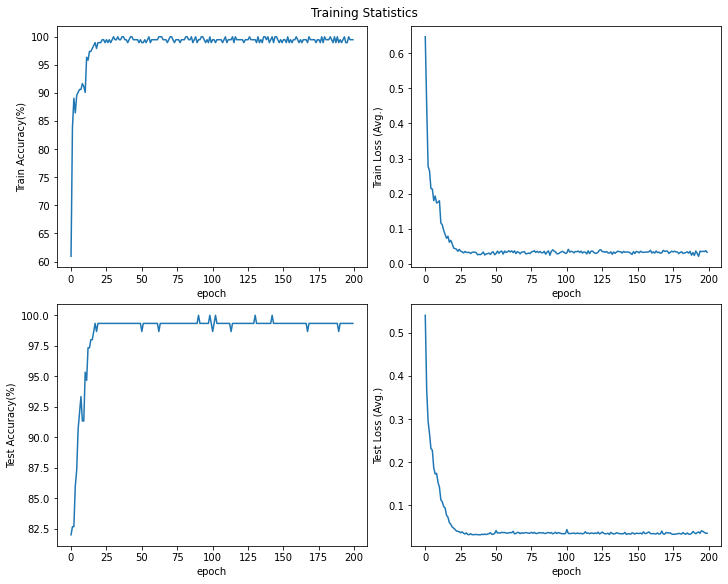

In [10]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc'] for h in history])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc'] for h in history])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()